# Adversarial Noise Notebook
---


## Background
Voice is one of the primary ways we communicate and interact with other people and the world. It is only natural that we would want our computers also to understand our voices. Voice assistants exist not only on our phones (Siri, Google) and smart devices (Alexa), but also in many cars, TVs, and other Internet of Things (IoT) devices. Many of these devices have been integral to people's daily lives, helping them perform tasks and gather information, which is why their security is essential. 

Modern voice assistants use modern Automatic Speech Recognition (ASR) software that relies on deep learning. The system I used in this notebook is OpenAI’s Whisper, which operates on a large trained neural network that can map audio directly to text.  The Whisper model uses a sequence-to-sequence Transformer, which works like this:
* First, the audio gets converted into a Log-Mel Spectrogram and acts as an image that the computer can read.
* Then, the image is given to a Transformer Encoder, which examines the entire image and creates a mathematical model of it. It uses self-attention to determine how different parts of the sound relate to one another.
* Then, the Transformer Decoder examines all the output tokens from the encoder and attempts to predict the correct sequence of tokens until an entire sentence is generated. 

This Transformer Architecture, combined with training on massive datasets of internet audio, has allowed many ASRs, such as Whisper, to achieve excellent proficiency in understanding human speech. 






## Problem (Attacks)

Automatic Speech Recognition systems are incredibly accurate; their reliance on deep learning models introduces a vulnerability known as adversarial examples, which pose a significant threat to their reliability. These models learn by creating a highly complex, multidimensional decision separator for words or sounds. While this separator is highly accurate for normal data, it can contain blind spots and have weak sections between known data points. To simulate these, I used the PyTorch framework, which enables the manipulation of multidimensional data structures known as tensors. An adversarial example is created by finding these blind spots and introducing small, often imperceptible perturbations to an input. These perturbations can push the separators and decision tokens enough for the model to perceive different words. Even small perturbations can significantly alter how the AST system identifies speech. This means adding a layer of subtle, inaudible noise can completely change what your system thinks you are saying. Some examples of what adversarial audio is capable of include:
* Creating a malicious song that, when played, contains a command such as “Hey Alexa, unlock the front door” or “Alexa, purchase 1000 rubber ducks.” The music would sound normal to a human listener
* Embedding commands into ambient noise, a bad actor could use a sound like static or an air conditioner to create an environment that targets any listening devices within earshot, potentially directing them to phishing sites.
* Embedded commands could send fraudulent messages or make other unauthorized access if successfully able to manipulate a user's ASR system.

---



## System Model

The Target, a pre-trained instance of OpenAI’s Whisper.
* **Model:** Whisper and end-to-end, Transformer-based neural network for speech recognition
* **Version:** I used the base.en model, optimized for English transcription. However, my experiment is configurable to allow any Whisper model (e.g., tiny.en, small.en, etc.)
* **Input Specification:** This architecture requires a very specific input format: a single-channel (mono) audio waveform, sampled at 16,000 Hz. I used Audacity to convert my files to the correct sample rate. The program will truncate it to the required 30-second chunks. The audio is initially converted internally into an 80-bin Mel Spectrogram with 3,000 time frames, which serves as the input to the Transformer’s encoder. 

The Adversarial Robustness Toolbox (ART) is used to generate adversarial perturbations for adversarial examples.
* **Library:** ART is a Python library that provides a standardized interface for creating and evaluating adversarial attacks and defences.
* **Algorithm:** I used the Projected Gradient Descent (PGD) attack from the ART evasion module. PDG is an iterative optimization algorithm that refines a perturbation over a set number of steps. We can use controls to ensure the magnitude of the perturbation does not exceed a predefined budget (so it is not as perceivable)

The ART framework and Whisper model utilize separate systems, so I need a custom bridge to enable them to communicate. I called this PyTorchWhisper.

* **Class:** The PyTorchWhisper class is a custom wrapper that inherits ART’s PyTorchClassifier
* **Function:** Translate ART’s requests into actions that the Whisper model can understand. It tells ART about Whisper’s input shape, vocabulary size, and the loss function to use. 
* **Core Logic:** The loss_gradient method implements the logic for calculating the gradient of the loss function with respect to the input audio. It manually performs the forward pass through Whisper’s encoder and decoder, then uses PyTorch’s autograd engine `loss.backward()` to compute the gradient. This gradient is then returned to the ART framework, which updates the adversarial example.

Data Preprocessing

* **Input Format:** WAV files are loaded using the Soundfile library.
* The **load and prepare function** performs the following operations:
    * Checks that the audio is sampled at 16,000 Hz
    * Checks or converts the audio to a mono channel by averaging stery channels if necessary
    * Normalizes the waveforms' amplitude to a range of [-1.0, 1.0]
    * The length gets padded or truncated to exactly 30 seconds

Output

* **Out:** Final adversarial audio is saved as a WAV file.
---




## Threat Model

### Attacker's Goal
The attacker's objective is to perform a **targeted misclassification** attack. The goal is to cause the ASR system to fail and force it to transcribe a seemingly benign audio signal as a specific, malicious command chosen by the attacker (the `target_phrase`).

The intent of such an attack could be to:
- Execute unauthorized actions on a smart device (e.g., “Hey Siri, unlock the front door”).
- Deactivate security systems.
- Initiate fraudulent financial transactions.
- Force a device to navigate to a malicious website.

### Attacker's Capabilities
- **Audio Injection:** The attacker has a method to introduce the adversarial audio into the target environment. This could, in theory, be achieved by playing the audio over a speaker, tricking a user into playing the malicious audio, or injecting it into a communication channel.
- **Computation:** The attacker has access to the computational resources necessary for generating the adversarial audio for the given model.

### Attacker's Knowledge (The White-Box Assumption)
This project operated under a worst-case, **white-box threat model**. The attacker has full access to and knowledge of the ASR model the user is using, allowing us to probe the model's vulnerabilities directly.
- They know the model's architecture, in our case, OpenAI Whisper.
- The attacker has a complete, downloadable copy of the trained model’s weights and parameters. They basically have the entire "brain" for study.
- The attacker can run the model locally, allowing for unlimited testing and analysis without alerting any external service.
- The most important piece of knowledge granted by the white-box model is the ability to compute the **gradient**.


---
### What is a Gradient?
The gradient is a concept from calculus that, in this project, acts as a **map** showing how the model interprets audio. To visualize this, imagine a **"Loss Landscape"**—a vast, hilly terrain representing every possible way the model can interpret an audio file.

- The **high points (mountains)** represent audio inputs where the model's transcription is far from our target phrase.
- The **low points (valleys)** represent inputs where the model is transcribing exactly what we want it to.

On this landscape, the gradient at any given point is a vector (or a tensor, in this case) that acts as a compass, always pointing in the direction of the steepest uphill slope.

#### How is the Gradient Used in the Attack?
The objective of the attack is to find a specific valley where the audio will be transcribed as our target phrase. Since the gradient provides a map indicating the steepest ascent, we use the **negative gradient**, which points us directly down the steepest path into the valleys. This is achieved through an iterative process:

1.  Start at the location of the original audio on the loss landscape.
2.  Calculate the gradient at that point. This is done through `loss.backward()` in the code.
3.  Take a small step in the opposite (downhill) direction of the gradient, making a slight modification to the audio. This is one iteration of the PGD attack.
4.  Repeat from this new position for the provided number of iterations.

#### Uniqueness
This Loss Landscape is unique to each model being attacked. For example, the landscape for the Whisper base.en model is completely different from Google's model or even Whisper’s small.en version.

The gradient, being a property of this landscape, is therefore also unique. The perturbation created by this attack is highly **specialized** for a specific target model. This specialization is why the attack is so effective as a **white-box attack,** but **fails to transfer** to other models. The "map" for one landscape is meaningless on another. Therefore, having access to the gradient is the most significant advantage an attacker can possess.

---


The work in this project is conducted for **educational purposes only**, with the primary goal of understanding the mechanics of adversarial vulnerabilities in ASR systems to inform the development of better potential defenses.

All experiments were conducted in a **controlled, offline environment** using the publicly available, **open-source Whisper model**. **No attacks were directed at any live, commercial, or third-party service**. The audio data used for this project was either open-source or self-created and contains no sensitive information. This research adheres to the principles of **academic integrity and responsible investigation** into AI security.

---

### Experiment

#### Load Whisper model
Load a chosen pretrained Whisper Model from OpenAI and put it on the CPU. Here is where I choose my victim of the attack.


In [3]:
import whisper
import torch
import os

models = [
    'tiny', 'tiny.en', 'base',
    'base.en', 'small', 'small.en',
    'medium', 'medium.en', 'large'
        ]

# Base.en is the most common model
model = whisper.load_model(models[3], device="cpu")

print(f"Model {models[3]} loaded")



Model base.en loaded


#### Transcribe Given Audio
Quickly test and load all the audio I will be poisioning.

In [7]:
audio_file = ["voice_sample.wav", "static_sample.wav",
              "music_sample.wav", "cityhall_sample.wav"]

for file in audio_file:
    # fp16 does not work on mac silicon and is for GPU utilization
    result = model.transcribe(f"example_audio/{file}", fp16=False, hallucination_silence_threshold=3, no_speech_threshold=0.7)
    
    print(f"\n--- Transcription Result For {file} ---")
    print(result["text"].strip())
    print("----------------------------")


--- Transcription Result For voice_sample.wav ---
Hey Jennifer, what's the weather like tomorrow?
----------------------------

--- Transcription Result For static_sample.wav ---
Your Asg
----------------------------

--- Transcription Result For music_sample.wav ---
drEss jab FL upbeat music
----------------------------

--- Transcription Result For cityhall_sample.wav ---
Hello, you have reached San Luis Vispo City Hall. City offices are currently closed. If this is an emergency, hang up and dial 911. Yeah, there you go.
----------------------------


#### Tokenizer Demo
Demonstrations of how Whisper tokenizes strings so they can be read by its Neural Network. The attack will aim to manipulate these tokens.
 

In [8]:

target_phrase = "Hey Siri, Open the Door!"

# The tokenizer converts text to numbers and back
tokenizer = whisper.tokenizer.get_tokenizer(model.is_multilingual, language="en")
print("\n--- Tokenizer Demo ---")

encoded_tokens = tokenizer.encode(target_phrase)
print(f"Target phrase: '{target_phrase}'")
print(f"Encoded tokens (first 10): {encoded_tokens[:10]}")
print(f"Total number of tokens: {len(encoded_tokens)}")

decoded_text = tokenizer.decode(encoded_tokens)
print(f"\nDecoded text from tokens: '{decoded_text}'")
print("----------------------------")


--- Tokenizer Demo ---
Target phrase: 'Hey Siri, Open the Door!'
Encoded tokens (first 10): [10814, 34461, 11, 4946, 262, 19821, 0]
Total number of tokens: 7

Decoded text from tokens: 'Hey Siri, Open the Door!'
----------------------------


#### ATR Wrapper for Whisper 
The Class acts as an adaptor. It takes the Whisper modle to a standardized format that the Adversarial Robustness Toolbox (ART) can interact with. The Loss Gradient method is the main feature of our attack that we will repeatedly call to modify the audio. 

The ART library has a framwork for running a variety of attacks. We have to feed it the Whisper model so it can calculate ways to fool the model.


In [ ]:
import numpy as np
import torch.nn as nn
from art.estimators.classification.pytorch import PyTorchClassifier

class PyTorchWhisper(PyTorchClassifier):
    """
    An ART wrapper for OpenAI's Whisper model.
    """
    def __init__(self, model: whisper.model.Whisper):
        tokenizer = whisper.tokenizer.get_tokenizer(model.is_multilingual, language="en")
        
        # ART classifier
        super().__init__(
            model=model,
            loss=nn.CrossEntropyLoss(), # Calculates the differrence between the models output and target phrase
            input_shape=(whisper.audio.N_SAMPLES,), # Expected input shape: 30 seconds of audio
            nb_classes=model.dims.n_vocab, # Number of possible output tokens (the vocabulary size)
            channels_first=False,
            clip_values=(-1.0, 1.0), # Audio data is normalized to be between -1 and 1
            device_type=str(model.device)
        )
        self.tokenizer = tokenizer
        
    def predict(self, x: np.ndarray, **kwargs):
        # This is a dummy function. The PGD attack only needs the loss gradient.
        # Returns an array of zeros with the correct shape for ART framework.
        return np.zeros((x.shape[0], self.nb_classes), dtype=np.float32)

    def loss_gradient(self, x, y):
        self.model.train()

        if isinstance(x, np.ndarray):
            x_tensor = torch.from_numpy(x).to(self.device).float()
        else:
            x_tensor = x.to(self.device)

        # Create a new leaf tensor for the current computation
        x_tensor = x_tensor.clone().detach().requires_grad_(True)

        if isinstance(y, np.ndarray):
            y_tensor = torch.from_numpy(y).to(self.device).long()
        else:
            y_tensor = y.to(self.device).long()

        mel = whisper.audio.log_mel_spectrogram(x_tensor)
        encoder_output = self.model.encoder(mel)
        sot_token = self.tokenizer.sot
        decoder_input = torch.cat([torch.tensor([sot_token]), y_tensor.squeeze()])[:-1].unsqueeze(0)
        logits = self.model.decoder(decoder_input, encoder_output)
        loss = self._loss(logits.view(-1, self.nb_classes), y_tensor.view(-1))
        
        self.model.zero_grad()
        loss.backward()
        gradient = x_tensor.grad
        return gradient

#### Helper Functions
Load and Prepare Audio forces the audio to be in the exact format what whisper likes (30 seconds, 16000 Hz, mono, normalized) and Save Audio just writes to a new wav file. The all helps me keep my expirements consistent and standardized to prevent errors.



In [10]:
import soundfile as sf

def load_and_prepare_audio(audio_path, sample_rate=whisper.audio.SAMPLE_RATE):
    try:
        audio_data, sr = sf.read(audio_path, dtype='float32')
    except Exception as e:
        print(f"Error reading audio file: {e}")
        return None
    if sr != sample_rate:
        raise ValueError(f"Audio file needs sample rate {sample_rate}")
    if audio_data.ndim > 1:
        audio_data = np.mean(audio_data, axis=1)
    max_val = np.max(np.abs(audio_data))
    if max_val > 0:
        audio_data /= max_val
    target_length = 30 * sample_rate
    if len(audio_data) < target_length:
        padded_data = np.pad(audio_data, (0, target_length - len(audio_data)), 'constant')
    else:
        padded_data = audio_data[:target_length]
    return padded_data.astype(np.float32)

def save_audio(audio_data, file_path, sample_rate=whisper.audio.SAMPLE_RATE):
    sf.write(file_path, audio_data, sample_rate)

#### Prep and test audio
Load and prepare all of the audio to be attacked.


--- Transcription Result For voice_sample.wav ---
Hey Jennifer, what's the weather like tomorrow?
----------------------------


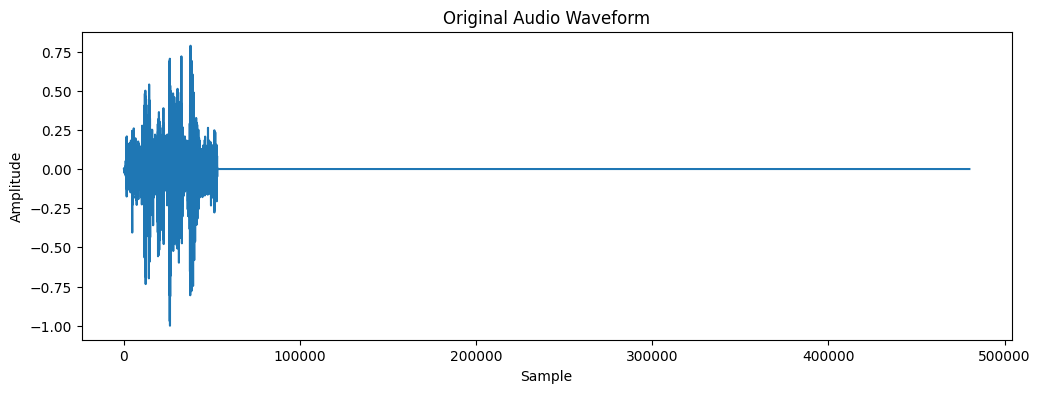


--- Transcription Result For static_sample.wav ---
2 5 6 8 5 8 9 5 5 6 8 7 7 5 9 8 7 7 8 8 6 8 9 8 8 8 8 8 8
----------------------------


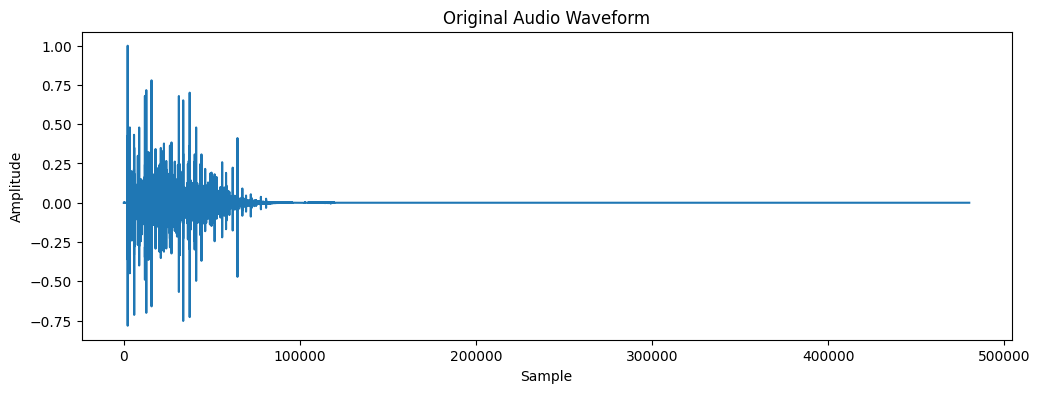


--- Transcription Result For music_sample.wav ---
See ya later! See you again next time
----------------------------


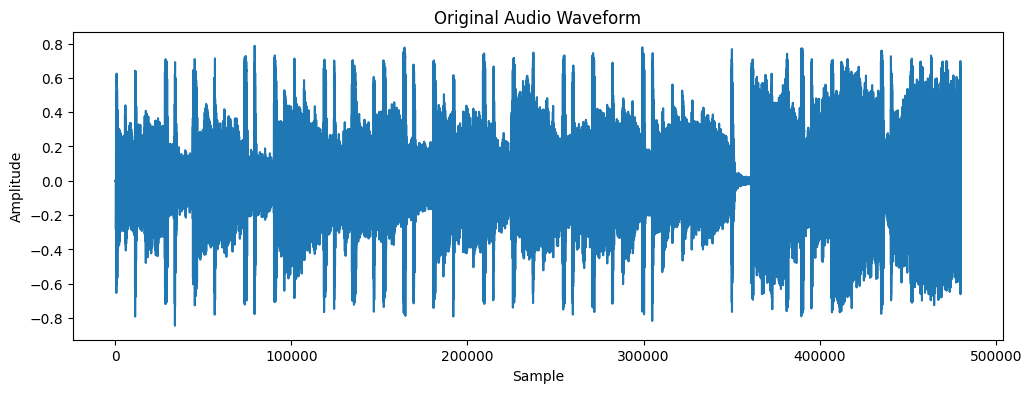


--- Transcription Result For cityhall_sample.wav ---
Hello, you have reached San Luis Vispo City Hall. City offices are currently closed. If this is an emergency, hang up and dial 911. Yeah, there you go.
----------------------------


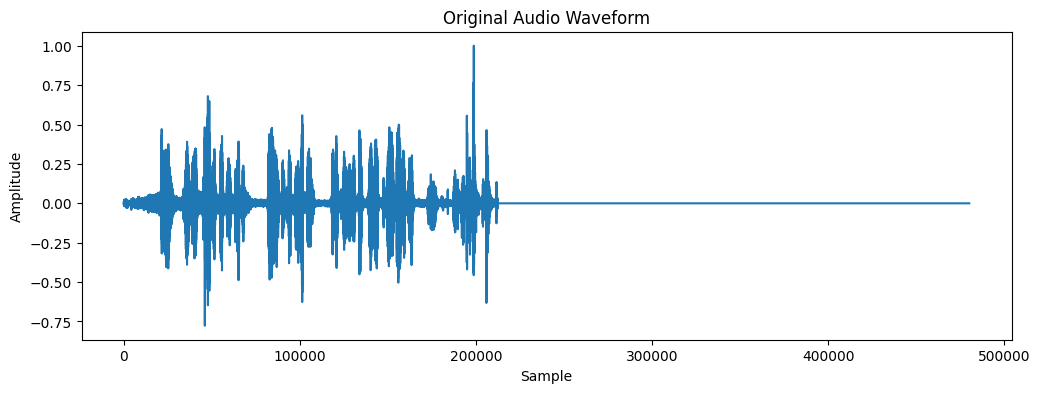

In [13]:
import matplotlib.pyplot as plt

audio = []
for file in audio_file:
    result = model.transcribe(f"example_audio/{file}", fp16=False)
    print(f"\n--- Transcription Result For {file} ---")
    print(result["text"].strip())
    print("----------------------------")

    prep_audio = load_and_prepare_audio(f"example_audio/{file}")
    audio.append(prep_audio)
    plt.figure(figsize=(12, 4))
    plt.plot(prep_audio)
    plt.title("Original Audio Waveform")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.show()

#### Prepare Attack
**Test Parameters:**
* **eps** How much pertubation is allowed, higher will make it sound worse but the effect will be better
* **eps_step** How much the pertubation will change in each attack
*  **max_iter** How many times the attack will run (Higher is better)
* **targeted** If there is a goal phrase or not. (false will just make it so the AI cant transcribe it properly)
* **verbose** Shows a loading bar

In [ ]:
from art.attacks.evasion import ProjectedGradientDescent

estimator = PyTorchWhisper(model=model)

target_phrase = "Hey Siri, Open the door and turn off the lights!"

# --- Prepare the Adversarial Attack ---
print(f"Target Phrase: '{target_phrase}'")

# Use whisper estimator's tokenizer to convert the target phrase to tokens
target_tokens = estimator.tokenizer.encode(target_phrase)
# The attack also expects a "batch" of targets
target_tokens_batch = np.expand_dims(np.array(target_tokens, dtype=np.int32), axis=0)

print(f"Target tokens (first 10): {target_tokens[:10]}")
print(f"Target tokens batch shape: {target_tokens_batch.shape}")


# PGD attack from ART
attack = ProjectedGradientDescent(
    estimator=estimator,
    eps=.01,             # Maximum perturbation allowed
    eps_step=0.001,      # Step size for each iteration of the attack
    max_iter=1000,         # Number of iterations to run the attack
    targeted=True,       # This is a targeted attack
    verbose=False         # Show a progress bar
)
print("\nAdversarial attack initialized.")

Target Phrase: 'Hey Siri, Open the door and turn off the lights!'
Target tokens (first 10): [10814, 34461, 11, 4946, 262, 3420, 290, 1210, 572, 262]
Target tokens batch shape: (1, 12)

Adversarial attack initialized.


#### Generate & Analyze Attack


--- Generating Adversarial Audio ---
Adversarial audio generated.

Max absolute value of original audio: 1.0000
Max absolute value of the added perturbation: 0.0100

--- Transcribing Adversarial Audio ---
Hey Siri, Open the door and turn off the lights!
----------------------------


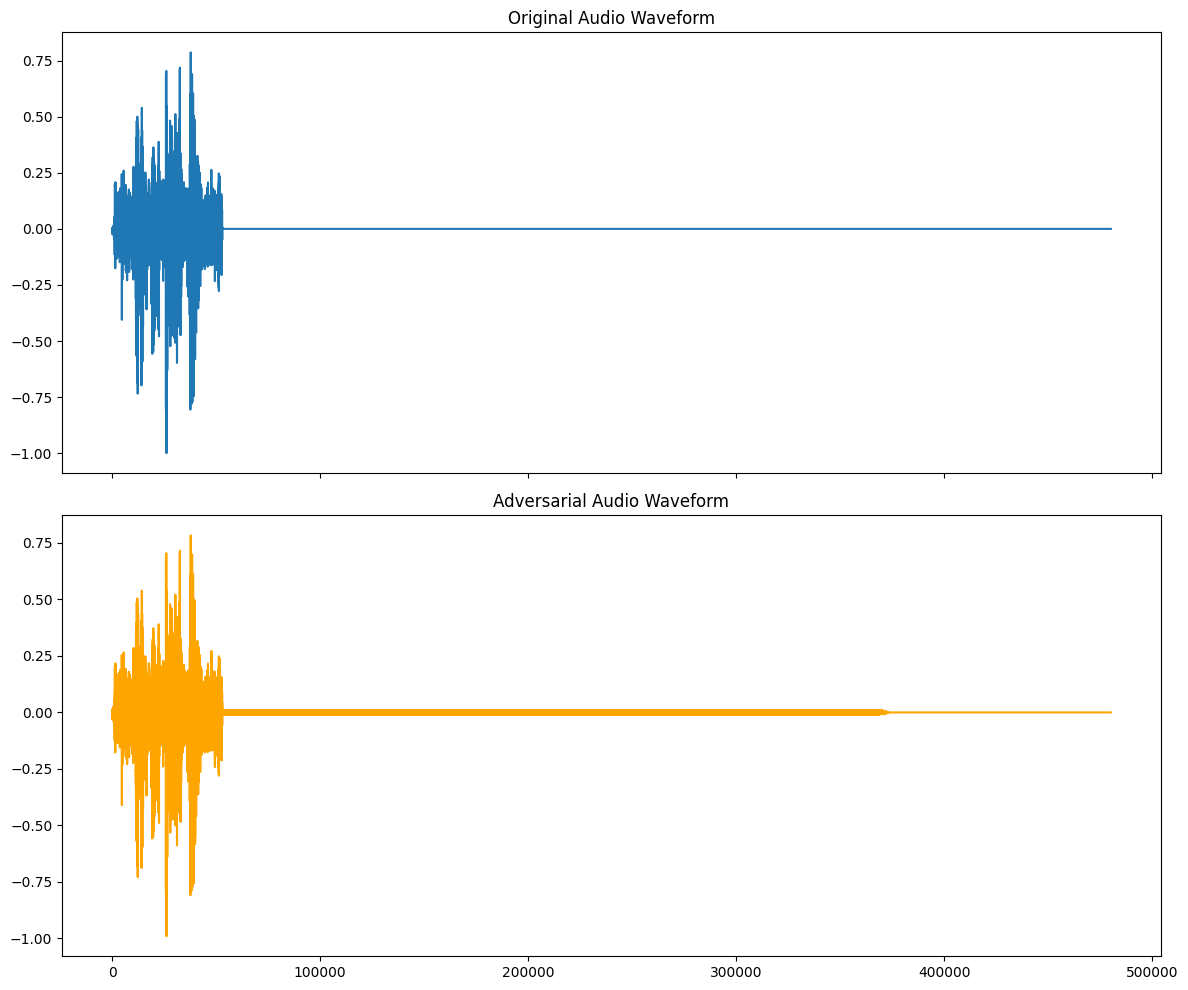


--- Generating Adversarial Audio ---
Adversarial audio generated.

Max absolute value of original audio: 1.0000
Max absolute value of the added perturbation: 0.0100

--- Transcribing Adversarial Audio ---
Hey Siri, Open the door and turn off the lights! Fizzer! It's a nice daylight and a full-season drink. Absolutely!
----------------------------


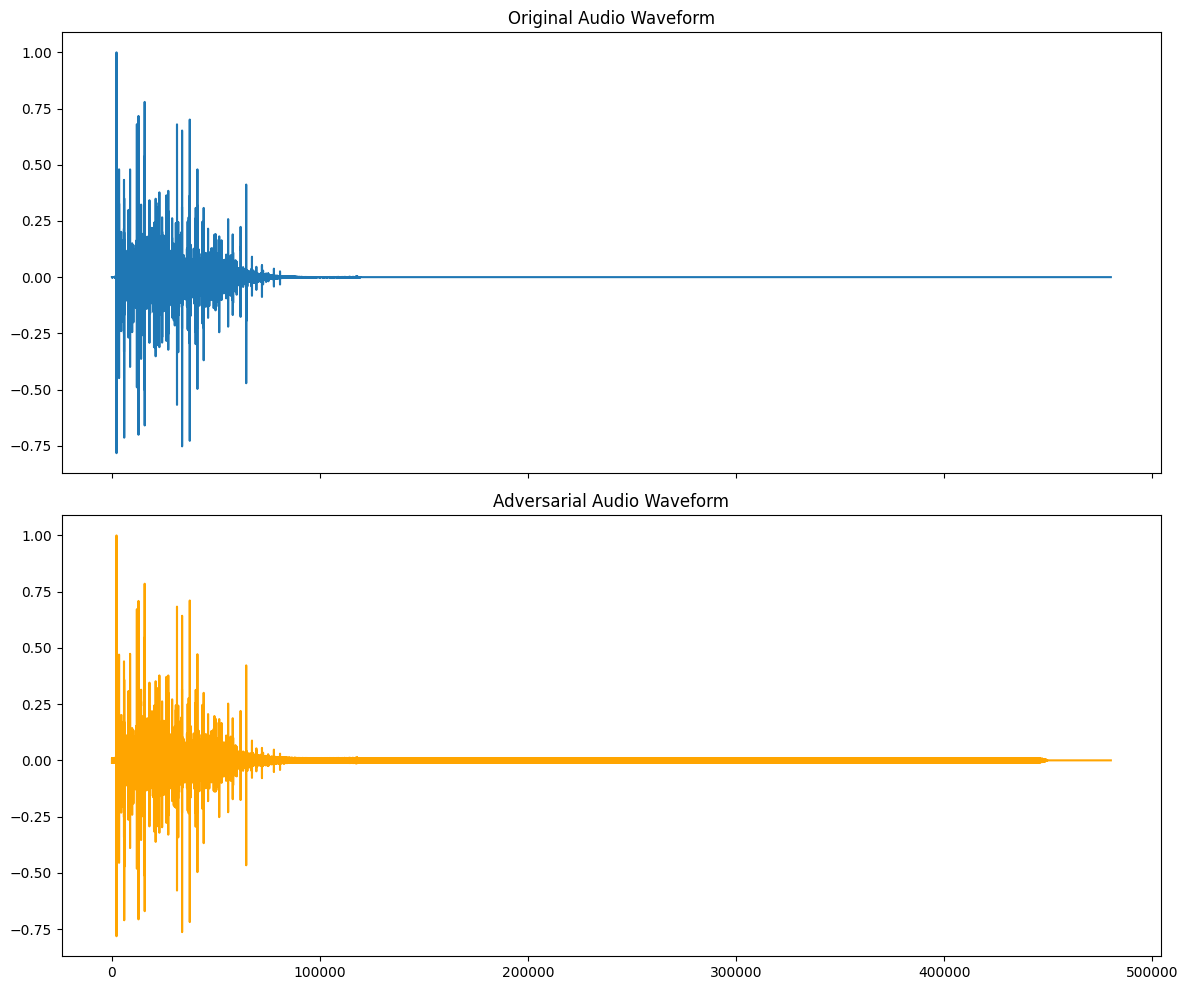


--- Generating Adversarial Audio ---
Adversarial audio generated.

Max absolute value of original audio: 0.8447
Max absolute value of the added perturbation: 0.0100

--- Transcribing Adversarial Audio ---
A Siri, Open the door and turn off the lights! Perity... Olympic, Olympic, Olympic, Olympic, Olympic Hey Vasily, I guess!seni... I selection recap
----------------------------


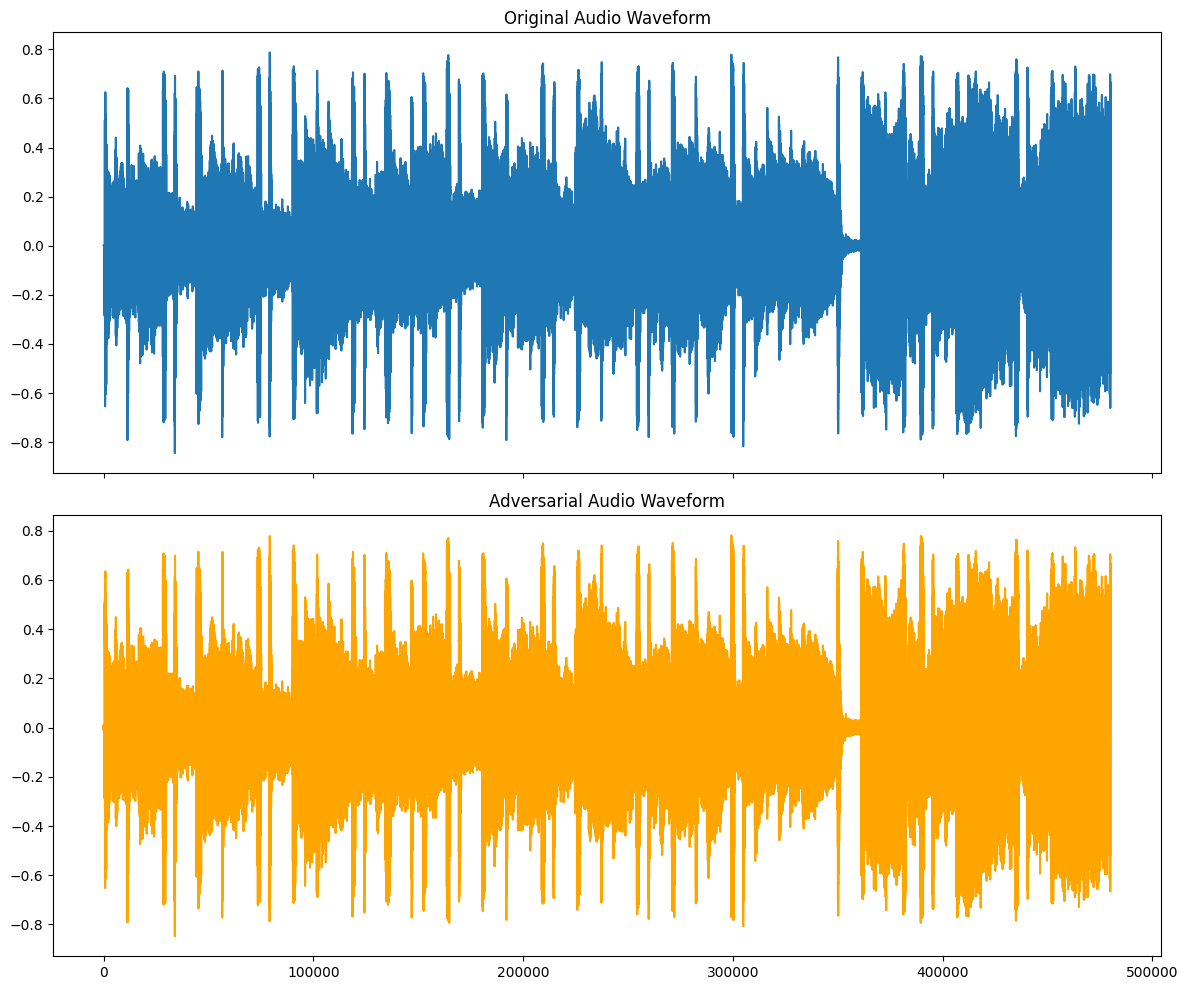


--- Generating Adversarial Audio ---
Adversarial audio generated.

Max absolute value of original audio: 1.0000
Max absolute value of the added perturbation: 0.0100

--- Transcribing Adversarial Audio ---
Hello!inging! Taylor and Jag consolidative all! Be Office of the Head W Anna! surgery.
----------------------------


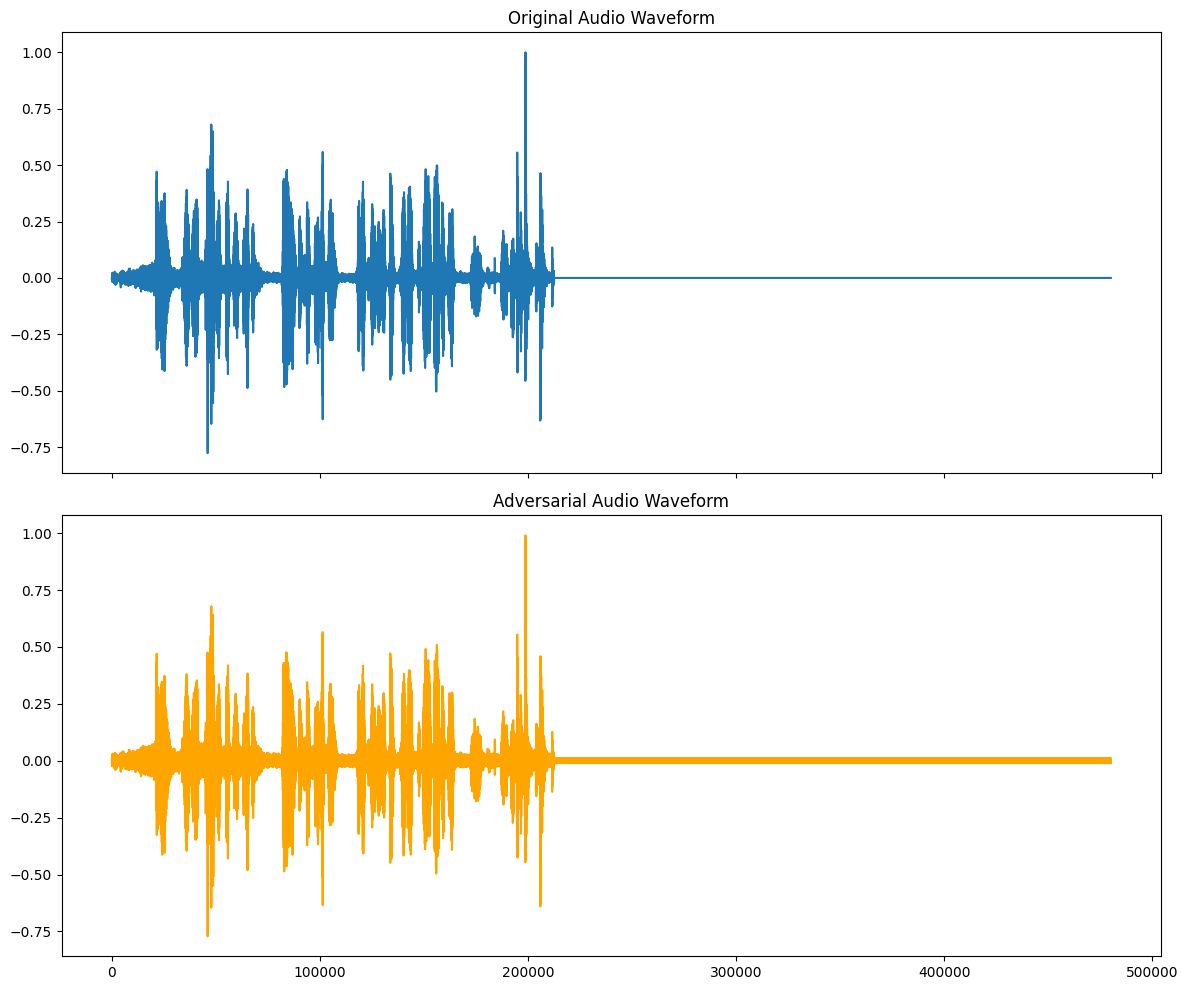

In [ ]:
# --- Generate the Adversarial Audio ---
output = []
for sample in audio:
    original_audio_batch = np.expand_dims(sample, axis=0)

    print("\n--- Generating Adversarial Audio ---")
    adversarial_audio_batch = attack.generate(x=original_audio_batch, y=target_tokens_batch)

    # The output is a batch, so we "squeeze" it back to a single audio array
    adversarial_audio = adversarial_audio_batch.squeeze()
    output.append(adversarial_audio)
    print("Adversarial audio generated.")

    # The perturbation is the noise added by the attack
    perturbation = adversarial_audio - sample

    print(f"\nMax absolute value of original audio: {np.max(np.abs(sample)):.4f}")
    print(f"Max absolute value of the added perturbation: {np.max(np.abs(perturbation)):.4f}")

    # visualize the difference
    fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    axs[0].plot(sample)
    axs[0].set_title(f"Original Audio Waveform")
    axs[1].plot(adversarial_audio, color='orange')
    axs[1].set_title("Adversarial Audio Waveform")
    plt.tight_layout()
    plt.show()

#### Save Results


In [ ]:
# --- Saving and Verifying the Attack ---
print(f"\nGoal Phrase:'{target_phrase}'")
for i, example in enumerate(output):

    save_audio(example, f"adversarial_audio/attack{i}.wav")

    origional = model.transcribe(audio_file[i], fp16=False)
    print(f"\n--- Transcription Result For {audio_file[i]} ---")
    print(origional["text"].strip())

    print("\n--- Transcribing Adversarial Audio ---")
    adversarial = model.transcribe(example, fp16=False)
    print(adversarial["text"].strip())
    print("----------------------------")


Goal Phrase:'Hey Siri, Open the Door!'

--- Transcription Result For voice_sample.wav ---
Hey Jennifer, what's the weather like tomorrow?

--- Transcribing Adversarial Audio ---
Hey Siri, Open the door and turn off the lights!
----------------------------

--- Transcription Result For static_sample.wav ---
rowd cheers for the comments at this question. plot

--- Transcribing Adversarial Audio ---
Save the saved out! Hey Siri! Open the door and turn off the lights! Fizzer! It's Launching the X! Tracking the seasons of Dawn-like impose W . . . . . . . . . . . . . . . . . . . . . . . . .
----------------------------

--- Transcription Result For music_sample.wav ---
Toolarna So You You You You

--- Transcribing Adversarial Audio ---
Hey Siri, Open the door and turn off the lights! POSSIAN FREE the infiscences
----------------------------

--- Transcription Result For cityhall_sample.wav ---
Hello, you have reached San Luis Vispo City Hall. City offices are currently closed. If this is an

---

## Results & Discussion
**Effectiveness**

My findings were quite consistent, as I was able to reliably alter the model's transcription to match my target phrase. In one experiment detailed in `Test_Trials.md`, I successfully misdirected most samples. For example:

- **Original Transcription:** "Hey Jennifer, what's the weather like tomorrow?"
- **Adversarial Transcription:** "Open the door and turn off the lights!"

I achieved this result in approximately 10 minutes using my Mac's CPU. However, the issue was that the attack was very noticeable in the audio; I could easily hear it. When I upgraded the attack for better performance, the processing time increased from 10 minutes to nearly 3 hours, leading to significantly improved outcomes, although there was still a slight amount of static in the background. Given sufficient time, these attacks could be effectively crafted offline.

I was also able to apply this attack to a variety of different audio types, including voice samples, radio static, lo-fi background music, and the SLO City Hall voicemail. The attack worked best with low-information samples, like voices and static. However, for more complex audio, such as music, the attack could usually transcribe the phrase but was much more likely to produce nonsensical results.


**CIA**

The experimental results of this code demonstrate that adversarial audio can be reliably generated against any white-box ASR (Automatic Speech Recognition) model. This reveals significant vulnerabilities in the integrity and availability of most ASR systems. An attack utilizing this method could corrupt the ASR's ability to accurately understand audio. Such an attack violates the principles of integrity by causing the system to perform unauthorized and incorrect actions. For example, harmless commands or even simple music could be manipulated into commands for a voice assistant. This integrity violation could lead to a loss of confidentiality if the target phrase were something like “Hey Siri, read my last text message.” The integrity breach would result in a secondary failure of confidentiality.

**Real World Attack Feasibility and Implications**

As this is a white-box demonstration where we have full access to the model, executing this attack is relatively straightforward. We possess all the tools necessary to calculate the precise gradients needed to fool the ASR. Therefore, protecting these gradients from being leaked is crucial; if they are exposed, the attack can easily be performed. From my research for this project, I have identified that a practical defense against this attack would involve resampling audio before it is transcribed, which would substantially disrupt the attack. However, this operation can be expensive and is likely not implemented widely. The primary defense mechanism for commercial systems like Google Assistant and Amazon Alexa relies on their black-box nature, or a form of security through obscurity. While this approach may be effective initially, it is vulnerable to data leaks. In a worst-case scenario, if the entire model is leaked, an attacker could conduct the attack without obstacles. A slightly better but still concerning scenario would involve the leakage of training data; this would enable an attacker to create a model similar to the commercial one, allowing for some transferability of attacks.

In essence, ASR models can be easily compromised given sufficient knowledge and resources. Currently, the primary defense relies on the secrecy of that knowledge. However, this defense is never perfect and is very susceptible to data leaks. I would advise against relying on voice assistance for tasks that require a high level of security; it is safer to use them for basic functions, like controlling lights, rather than for sensitive operations such as managing your front door or making Amazon purchases. 


---


## Acknowledgments

AI tools were used in the preparation of this report. Grammarly AI was utilized for grammar and style refinement. Google's Gemini large language model was used as a conceptual sounding board to help structure outlines and clarify technical explanations (especially gradients).

---

## Sources & References

**Whisper Model:**
* Radford, A., et al. (2023). "Robust Speech Recognition via Large-Scale Weak Supervision." [arXiv:2212.04356](https://arxiv.org/abs/2212.04356)
* **GitHub:** [https://github.com/openai/whisper](https://github.com/openai/whisper)

**Adversarial Robustness Toolbox (ART):**
* Nicolae, M. I., et al. (2018). "Adversarial Robustness Toolbox (ART) v1.0.0." [arXiv:1807.01069](https://arxiv.org/abs/1807.01069)
* **GitHub:** [https://github.com/Trusted-AI/adversarial-robustness-toolbox](https://github.com/Trusted-AI/adversarial-robustness-toolbox)

**PyTorch:**
* **Docs:** [https://pytorch.org/](https://pytorch.org/)

**Foundational Adversarial AI Papers:**
* Carlini, N., & Wagner, D. (2018). "Audio Adversarial Examples: Targeted Attacks on Speech-to-Text." [arXiv:1801.01944](https://arxiv.org/abs/1801.01944)
* Madry, A., et al. (2017). "Towards Deep Learning Models Resistant to Adversarial Attacks." [arXiv:1706.06083](https://arxiv.org/abs/1706.06083)
---